In [ ]:
# !pip freeze | grep -E '^(torch|kaggle)' > requirements.txt

In [1]:
# Imports
import torch
import numpy as np

In [2]:
from data_loader import load_datasets

x_train, y_train = load_datasets(size = 100)
x_test,  y_test = load_datasets(train_or_test_folder="Test_Alphabet",size=100)

print(f"Train dataset count: {len(x_train)} \nTest dataset count: {len(x_test)} ")

Loading datasets:  A B Blank C D E F G H I J K L M N O P Q R S T U V W X Y Z 

Loading datasets:  A B Blank C D E F G H I J K L M N O P Q R S T U V W X Y Z 

Train dataset count: 24300 
Test dataset count: 2700 


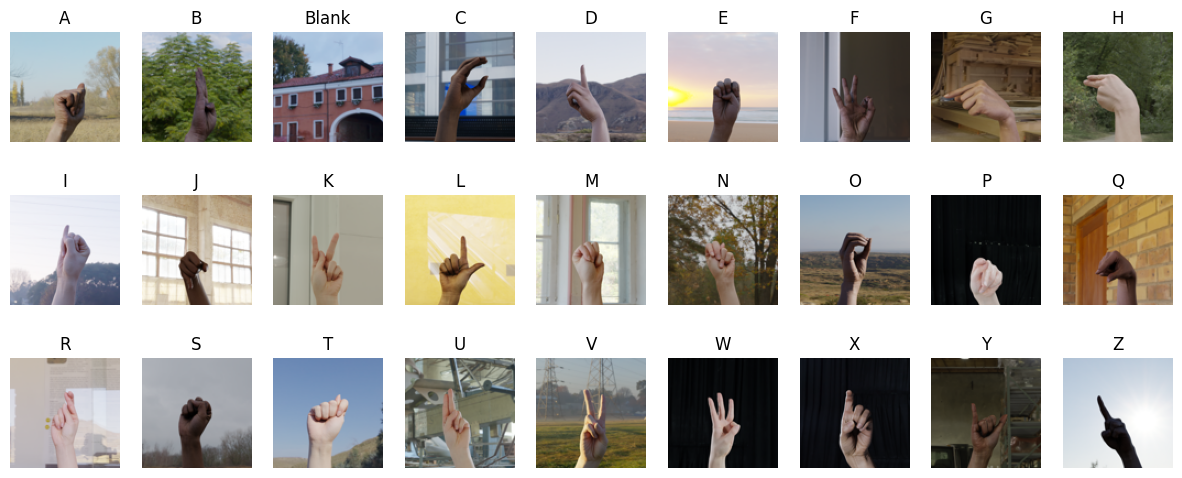

In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline

fig, axes = plt.subplots(3, 9, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    image_index = i * 900 + 1
    ax.imshow(x_train[image_index].permute(1, 2, 0))
    ax.set_title(y_train[image_index])
    ax.axis('off')

plt.show()

**One-Hot Coding**

In [4]:
from data_loader import alphabet_to_num

def one_hot_coding(unique_labels, data):
    y_oh = torch.zeros(len(data),unique_labels)
    for i, class_word in enumerate(data):
        index = alphabet_to_num(class_word)
        y_oh[i][index] = 1

    return y_oh
y_train,y_test = np.array(y_train),np.array(y_test)
y_train_oh = one_hot_coding(len(np.unique(y_train)),y_train)
y_test_oh = one_hot_coding(len(np.unique(y_train)),y_test)

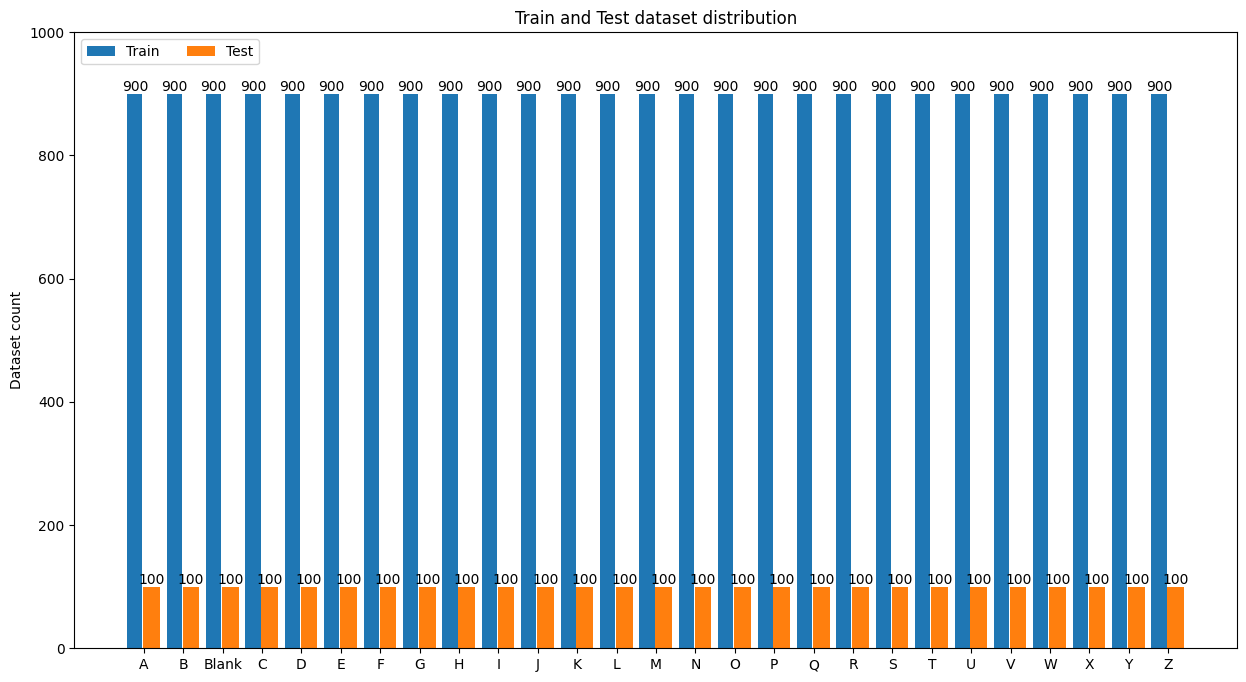

In [54]:
import matplotlib.pyplot as plt
import numpy as np

labels, train_counts = np.unique(y_train,return_counts=True)
_, test_counts = np.unique(y_test,return_counts=True)


width = 0.5 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 8))
x_array = np.arange(len(labels))*1.3
for _count in [train_counts,test_counts]:
    offset = width*multiplier
    ract = ax.bar(x_array+offset,_count,width=width,label = "Train" if multiplier == 0 else "Test")
    ax.bar_label(ract,)
    multiplier+=1
    width+=0.05
ax.set_title('Train and Test dataset distribution')
ax.legend(loc='upper left',ncols=2)
ax.set_xticks(x_array + width*0.5, labels)
ax.set_ylabel('Dataset count')
ax.set_ylim(0, 1000)
    
plt.show()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, padding=2)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=15, kernel_size=5, padding=2)
        # Another max pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        # Fully connected layer
        self.fc1 = nn.Linear(15 * 6 * 6, 27)  # 3x3 is the size after two max pooling layers

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 15 * 6 * 6)  # Flatten the output of conv2 layer
        x = self.fc1(x)
        return x

# Instantiate the model
model = ConvNet()
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=0.01)

# Print the model architecture
print(model)


ConvNet(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=540, out_features=27, bias=True)
)


In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(torch.tensor(x_train),torch.tensor(y_train_oh)), 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(x_test),torch.tensor(y_test_oh)), 
                          batch_size=batch_size)

C:\Users\amit_kuma1\AppData\Local\Temp\ipykernel_25328\4175538580.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(x_train),torch.tensor(y_train_oh)),
C:\Users\amit_kuma1\AppData\Local\Temp\ipykernel_25328\4175538580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loader = DataLoader(TensorDataset(torch.tensor(x_test),torch.tensor(y_test_oh)),


In [13]:
def train_model(model,criterion,optimizer,num_epochs=50):
    for epoch in range(num_epochs):
        running_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")


train_model(model=model, criterion=criterion, optimizer=optimizer) 

Epoch [1/50], Train Loss: 3.5605
Epoch [2/50], Train Loss: 3.2988


KeyboardInterrupt: 

: 

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, labels_indices = torch.max(labels, 1)  # Convert one-hot labels to indices
            total += labels.size(0)
            correct += (predicted == labels_indices).sum().item()
    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")


test_model(model=model,test_loader=test_loader)